In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold, preprocessing
from sklearn.neural_network import MLPClassifier
import math
import copy
from tqdm import tqdm
from scipy.sparse import csr_matrix, csgraph
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

plt.style.use("seaborn-v0_8")
sns.set(color_codes=True)
seed = 10

In [2]:
# Generate synthetic dataset

def create_synthetic_dataset(num_points_top, num_points_left, num_points_middle, num_points_right):
    np.random.seed(seed)
    num_features = 2
    
    # top cluster
    mu_top = [0.2, 0.7]
    sigma_top = [0.1, 0.1]
    # num_points_top = 100
    cluster_top_X = np.random.normal(mu_top, sigma_top, (num_points_top, num_features))
    cluster_top_y = np.zeros(num_points_top)
    
    # left cluster    
    mu_left = [0.15, 0.3]
    sigma_left = [0.1, 0.1]
    # num_points_bottom = 100
    cluster_left_X = np.random.normal(mu_left, sigma_left, (num_points_left, num_features))
    cluster_left_y = np.ones(num_points_left)
    
    # middle cluster
    mu_middle = [0.5, 0.4]
    sigma_middle = [0.1, 0.1]
    # num_points_middle = 50
    cluster_middle_X = np.random.normal(mu_middle, sigma_middle, (num_points_middle, num_features))
    cluster_middle_y = np.ones(num_points_middle)

    # right vertical cluster
    mu_right = [0.7, 0.7]
    sigma_right = [0.1, 0.1]
    # num_points_right = 150
    cluster_right_X = np.random.normal(mu_right, sigma_right, (num_points_right, num_features))
    cluster_right_y = np.ones(num_points_right)

    X = np.concatenate((cluster_top_X, cluster_left_X, cluster_middle_X, cluster_right_X), axis=0)
    y = np.concatenate((cluster_top_y, cluster_left_y,  cluster_middle_y, cluster_right_y))

    df = pd.DataFrame(preprocessing.minmax_scale(X), columns=["x1", "x2"])
    df["y"] = y

    return df

In [3]:
num_points_top = 100
num_points_left = 70
num_points_middle = 70
num_points_right = 70

df = create_synthetic_dataset(num_points_top, num_points_left, num_points_middle, num_points_right)

In [68]:
def plot_counterfactual_explanations(df, predictor, node_paths):
    fig, ax = plt.subplots(figsize=(7,6))

    ax = plot_dataset(ax, df)
    X = df[["x1", "x2"]]
    ax = plot_decision_boundary(ax, X, predictor)
    # plot_counterfactual_candidates(ax, X, sorted_cf_indices)
    # plot_one_path(ax, X, node_paths)
    
    path_colors = mpl.cm.Greens(np.linspace(0,1,len(list(node_paths.values())[0])))
    for path_idx, path in enumerate((list(node_paths.values())[0]).values()):
        plot_one_path(ax, X, path, color=path_colors[path_idx])
    plt.show()


def plot_dataset(ax, df):
    # Plot the dataset.
    dots_color_mapping = mpl.colors.ListedColormap(["#7B90D2", "#FAD689"])
    # dots_color_mapping =["b"]*num_points_top + ["r"]*num_points_left + ["#FAD689"]*num_points_middle + ["sienna"]*num_points_right

    ax.scatter(df.x1, df.x2, c=df.y, 
               cmap=dots_color_mapping, s=30,
            #    edgecolors = 'black',
               zorder = 1)
    
    ax.grid(color="grey", linestyle = "--", linewidth= 0.5, alpha=0.75)

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$x_1~\longrightarrow$")
    ax.set_ylabel(r"$x_2~\longleftrightarrow$")

    return ax

def plot_decision_boundary(ax, X_scaled, predictor):
    h=0.01
    x1_min, x2_min = np.min(X_scaled, axis=0)
    x1_max, x2_max = np.max(X_scaled, axis=0)

    x1_cords, x2_cords = np.meshgrid(
        np.arange(x1_min, x1_max, h),
        np.arange(x2_min, x2_max, h)
    )
    new_X = np.c_[x1_cords.ravel(), x2_cords.ravel()]
    new_X_df = pd.DataFrame(new_X, columns=["x1", "x2"])
    
    def predict_func(X):
        return predictor.predict_proba(X)[:, 1]

    height_values = predict_func(new_X_df)
    height_values = height_values.reshape(x1_cords.shape)
 
    contour = ax.contourf(
        x1_cords, 
        x2_cords,  
        height_values,
        levels = 20, 
        cmap = plt.cm.RdBu,
        alpha = 0.8,
        zorder = 0
    )

    plt.colorbar(contour, ax=ax, fraction = 0.1)
    return ax

def plot_counterfactual_candidates(ax, X, sorted_cf_indices):
    ax.scatter(X.iloc[sorted_cf_indices, 0], X.iloc[sorted_cf_indices, 1], color="grey")

def plot_one_path(ax, X, node_path, color="grey"):  
    ax.scatter(X.iloc[node_path, 0], X.iloc[node_path, 1], color="black", alpha=0.7, s=30)
    # connects points
    for node_num in range(len(node_path)-1):
        i = node_path[node_num]
        j = node_path[node_num+1]
        ax.plot(X.iloc[[i, j], 0], X.iloc[[i,j], 1], color = color, alpha=0.7)
    



In [ ]:
# Unsupervised clustering (t-SNE, UMAP)

t_sne = manifold.TSNE(
    n_components= 2,
    perplexity=10,
    init="random",
    n_iter=250,
    random_state=0
)

synthetic_t_sne = t_sne.fit_transform(df.iloc[:, :2])
print(synthetic_t_sne.shape)


In [ ]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(6, 6), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50)
    ax.set_title(title)
    # ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # ax.yaxis.set_major_formatter(ticker.NullFormatter())
plot_2d(synthetic_t_sne, dots_color_mapping, "title")

Visualising the MNIST dataset
https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

Hierarchical clustering
https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp



## Path findings with FaceLift

In [5]:
X = df.iloc[:, :2]
y = df.y
clf = MLPClassifier(max_iter=500).fit(X, y)
print(clf.score(X, y))
predictions = clf.predict_proba(X)

0.9580645161290322


c:\Users\s3964913\Anaconda3\envs\facelift\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [6]:
def calculate_weighted_distance(v0, v1, penalty_term = 2):
    diff = np.subtract(v0, v1)
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    penalty_term = 2,
    weight_func = None
    ):
    n_samples, n_ftrs = X.shape
    
    k = np.zeros((n_samples, n_samples))
    W = copy.deepcopy(k)
    X = X.to_numpy()

    for i in tqdm(range(n_samples)):
        v0 = X[i]
        for j in range(n_samples):
            v1 = X[j]
            # modify the distance function so that removing pixels incurring larger cost.
            # dist = calculate_weighted_distance(v1, v0, penalty_term=penalty_term)
            dist = np.linalg.norm(v0 - v1)
            k[i, j] = dist

            if dist != 0:
                # dist should be greater than r
                W[i,j] = weight_func(dist)
        
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        k[i, mask] = 0
        W[i, mask] = 0

    return k

In [7]:
def construct_graph(weight_matrix):
    graph = csr_matrix(weight_matrix)
    return graph

def find_shortest_path(graph, start_point_idx):
    dist_matrix, predecessors = csgraph.dijkstra(
        csgraph=graph, directed=True, indices=start_point_idx, return_predecessors=True
    )
    return dist_matrix, predecessors

def reconstruct_shortest_path(predecessors, start_point_idx, end_point_idx):
    """Get all the nodes along the path between the start point and the end point. 

    Args:
        predecessors (matrix of shape (1, n_nodes)): contain the previous node in the path.
        start_point_idx (int): the index of the start data point
        end_point_idx (int): the index of the end data point

    Returns:
        node_path (list): [start_point_idx, intermedium points index, end_point_idx]
    """
    if predecessors[end_point_idx] == start_point_idx:
        node_path = [end_point_idx]
    else:
        node_path = []
    intermedium_idx = end_point_idx
    while (predecessors[intermedium_idx] != start_point_idx):
        node_path.append(intermedium_idx)
        intermedium_idx = predecessors[intermedium_idx]
    if intermedium_idx != node_path[-1]:
        node_path.append(intermedium_idx)
    node_path.append(start_point_idx)
    
    return node_path[::-1]
 
def build_symmetric_matrix(kernel):
    for i in range(kernel.shape[0]):
        for j in range(i):
            if kernel[j, i] != 0:
                kernel[i, j] = kernel[j, i]
            else:
                kernel[j, i] = kernel[i, j]
    return kernel

def build_asymmetric_matrix(kernel, X, weight_func, penalty_term):
    n_samples = kernel.shape[0]
    X = X.to_numpy()
    for i in tqdm(range(n_samples)):
        for j in range(n_samples):
            if kernel[i,j] != 0:
                v0 = X[i]
                v1 = X[j]
                dist = calculate_weighted_distance(v0, v1, penalty_term=penalty_term)
                kernel[j, i] = weight_func(dist)
    return kernel

In [8]:
n_neighbours = 10
penalty_term = 1.1
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(n_features)
r = (n_neighbours / (n_samples * volume_sphere))
# print(r)    # 0.010

# Construct the global weighted graph.
# Kernel is asymmetric if using KNN to get weight, and OG only keeps the bottom left half of the matrix
weight_func=lambda x: -x*np.log(r/x)  # x**alpha
kernel = get_weights_kNN(
            X,
            penalty_term=penalty_term,
            n_neighbours=int(n_neighbours),
            weight_func=weight_func
        )
sym_kernel = build_symmetric_matrix(kernel)

100%|██████████| 310/310 [00:00<00:00, 418.42it/s]


In [9]:
def get_minimum_dist(dist_matrix):
    """get the shortest distance and its data index
    Args:
        dist_matrix (array): shape: 1 x n_nodes

    Returns:
        min_dist: minimum distance in the distance matrix
        min_dist_idx: index of the data point with the shortest dist
    """
    min_dist = np.min(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False)) 
    min_dist_idx = np.argmin(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False))
    return min_dist, min_dist_idx

def get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths = 1, pred_threshold=0.95):
    assert num_paths > 0 and isinstance(num_paths, int), "only positive integers"
    end_point_idx = []
    path_count = 0
    for idx in np.argsort(np.ma.masked_where(dist_matrix==0, dist_matrix)):
        if (y[idx] == target_class and
        predictions[idx, class_labels.index(target_class)] >= pred_threshold): 
            end_point_idx.append(idx)
            if path_count >= num_paths-1:
                break
            else:
                path_count += 1
    return end_point_idx

In [10]:
sp_graph = construct_graph(sym_kernel)
start_point_idx = 8
target_class = 1
class_labels = list(map(int, clf.classes_))
res = {}
res[start_point_idx] = {}

dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)

end_point_indices = get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths=10)
print(end_point_indices)

for order, end_point_idx in enumerate(end_point_indices):
    shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
    for node_idx in shortest_path[:-1]:
        res[start_point_idx][order] = shortest_path
print(res)

[177, 202, 232, 175, 157, 167, 124, 225, 235, 189]
{8: {0: [8, 87, 15, 65, 59, 49, 177], 1: [8, 87, 15, 65, 59, 49, 202], 2: [8, 87, 15, 65, 59, 49, 232], 3: [8, 87, 15, 65, 59, 49, 175], 4: [8, 96, 39, 60, 206, 42, 109, 157], 5: [8, 96, 39, 60, 206, 42, 109, 167], 6: [8, 87, 15, 65, 59, 49, 177, 124], 7: [8, 87, 15, 65, 59, 49, 202, 225], 8: [8, 48, 77, 4, 18, 20, 99, 56, 235], 9: [8, 87, 15, 65, 59, 49, 220, 189]}}


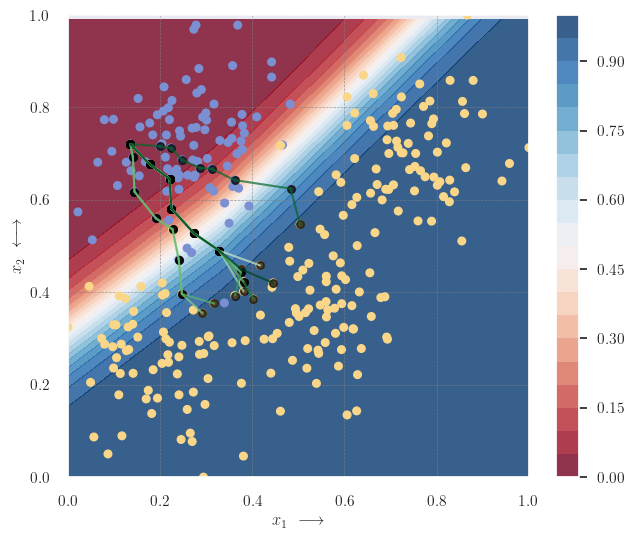

In [69]:
# node_path = [7, 3, 95, 18, 2, 33, 49, 177]
node_path = res[start_point_idx][4]

plot_counterfactual_explanations(df, clf, res)

## k-means clustering and visualisation

In [18]:
n_clusters = 4
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=seed
)
kmeans.fit(X)
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels = kmeans.labels_
print(k_means_cluster_centers)

[[0.1989673  0.26168163]
 [0.74240436 0.70445514]
 [0.53510245 0.35999968]
 [0.26452641 0.70813616]]


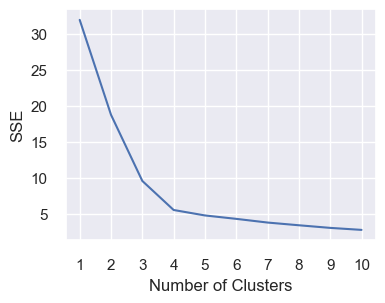

In [135]:
# determine the appropriate number of clusters
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(4,3))
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [19]:
def get_cluster_sd(k_means_labels, X):
    labels = sorted(set(k_means_labels))
    sd_coords = []
    for label in labels:
        sds = X.loc[np.where(k_means_labels==label)].std()
        sd_coords.append((sds.x1, sds.x2))
    return sd_coords

def add_ellipse(mu_x1, mu_x2, sd_x1, sd_x2, ax, edge_color):
    # one SD contour
    ellipse_sd = mpl.patches.Ellipse((mu_x1, mu_x2), width=2*sd_x1, height=2*sd_x2, fc="none", edgecolor=edge_color, linestyle="--", label=r"$1\sigma$")
    ax.add_patch(ellipse_sd)
    
    # two SD contour
    ellipse_2sd = mpl.patches.Ellipse((mu_x1, mu_x2), width=4*sd_x1, height=4*sd_x2, fc="none", edgecolor=edge_color, linestyle=":", label=r"$2\sigma$")  
    ax.add_patch(ellipse_2sd)
    return ax

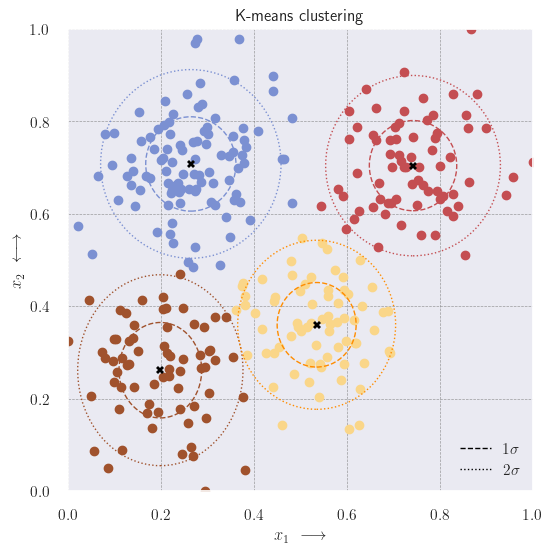

In [67]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
fig, ax = plt.subplots(figsize=(6, 6))

colors = ["sienna", "r", "#FAD689", "#7B90D2"]

for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(X.iloc[my_members, 0], X.iloc[my_members, 1], c=col)
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "X",
        markerfacecolor="black",
        markersize=6,
    )

ax.set_title("K-means clustering")
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.grid(color="grey", linestyle = "--", linewidth= 0.5, alpha=0.75)
ax.set_xlabel(r"$x_1~\longrightarrow$")
ax.set_ylabel(r"$x_2~\longleftrightarrow$")

contour_colors = ["sienna", "r", "darkorange", "#7B90D2"]
sd_coords = get_cluster_sd(k_means_labels, X)
for center_idx, mu in enumerate(k_means_cluster_centers):
    add_ellipse(mu[0], mu[1], sd_coords[center_idx][0], sd_coords[center_idx][1], ax, contour_colors[center_idx])

legend_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1, linestyle=":")]

ax.legend(legend_lines, [r'$1\sigma$', r'$2\sigma$'], loc="lower right")

plt.show()